In [1]:
from datetime import datetime
import pandas as pd

def get_historical_data_url(ticker):
    unix_oldest_date = 0
    unix_newest_date = int(datetime.now().timestamp())
    return f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={unix_oldest_date}&period2={unix_newest_date}&interval=1d&events=history&includeAdjustedClose=true"

get_historical_data_url("AAPL")

def download_data(ticker):
    url = get_historical_data_url(ticker)
    df = pd.read_csv(url)
    # filename = f"{ticker}.csv"
    # df.to_csv(filename)
    return df



### RSI CALCULATOR


In [2]:
def normalize(df, column="Volume"):
    df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df



#### Gain loss

In [3]:
def get_gain_los(data):
    loss = []
    gain = []
    for i in range(len(data)):
        difference = data[i]-data[i-1]
        if(i != 0):
            if(difference <= 0):
                loss.append(-1 * difference)
            elif(difference > 0):
                gain.append(difference)
    return loss, gain

def get_average_gain_loss(data):
  loss, gain = get_gain_los(data)
  avg_loss = 0
  avg_gain = 0
  if(len(loss) != 0):
    avg_loss = sum(loss)/len(loss)

  if(len(gain) != 0):
    avg_gain = sum(gain)/len(gain)

  return avg_loss, avg_gain

# loss, gain = get_gain_los([20,19,50,45,68,46,65,65,84,52,57,65,98,12,34])
# sum(gain)/len(gain), sum(loss)/len(loss)

#### RSI

In [4]:
def get_rsi(data):
    loss, gain = get_average_gain_loss(data)
    if loss != 0:
      rs = gain / loss
      rsi = 100 - (100 / (1 + rs))
      return rsi
    else:
      return 0

def get_rsi_column(data, count, onlyLast = False):
  rsi_row = []
  for i in range(len(data)):
    i += 1
    start = i - count
    if start < 0:
      start = 0
    rsi_value = (get_rsi(data[start:i]))
    if rsi_value != 0:
      rsi_row.append(rsi_value)
    else:
      rsi_row.append(0)
  return rsi_row


# get_rsi_column([20,19,50,45,68,46,65,65,84,52,57,65,98,32,39], 14)

Berekenen van Bollinger bands

In [5]:
import numpy as np

def calculate_boba_row(df,count, onlyLastOne=False):
  # df = data.copy()
  # df["SMA"] = df["Open"].copy()
  # sd = df["Open"].copy()
  if not onlyLastOne:
    df["SMA"] = df['Open'].rolling(window=count).mean()
    df["SD"] = df['Open'].rolling(window=count).std()
    upper_band_row = df["SMA"] + (2 * df["SD"])
    lower_band_row = df["SMA"] - (2 * df["SD"])
    df.drop(columns=["SMA", "SD"], inplace=True)
  elif onlyLastOne:
    sma = df['Open'][-count:].mean()
    sd = df['Open'][-count:].std()
    df[f"upper_band_{count}"].iloc[-1] = sma + (2 * sd)
    df[f"lower_band_{count}"].iloc[-1] =sma - (2 * sd)
    lower_band_row = df[f"lower_band_{count}"]
    upper_band_row = df[f"upper_band_{count}"]
  # Bereken Upper en Lower Bollinger Bands
 
  return upper_band_row, lower_band_row


Dataframe klaarmaken en ophalen

average volumes berekenen

In [6]:
def calculate_avg_volumes(df, count,onlyLastOne=False):
  # Bereken het gemiddelde volume van de voorgaande
  if not onlyLastOne:
    df['avg_volume'] = df['Volume'].rolling(window=count).mean()
    df['avg_open'] = df['Open'].rolling(window=count).mean()
  else:
    df['avg_volume'].iloc[-1:] = df['Volume'][-count:].mean()
    df['avg_open'].iloc[-1:] = df['Open'][-count:].mean()
  return df

rsi berekenen

In [7]:
def calculate_rsi_df(df, count, onlyLastOne=False):
    # Bereken de RSI-waarde
    df[f"Rsi{count}"] = get_rsi_column(df["Open"].array,count,onlyLastOne)
    return df

bollinger bands berekenen

In [8]:
def calculate_boba_df(df, count, onlyLastOne=False):
  #Bereken bollinger bands
    df[f"lower_band_{count}"], df[f"upper_band_{count}"] = calculate_boba_row(df,count, onlyLastOne)
    return df

datum naar unix time

In [9]:
from datetime import datetime
def convert_dates_to_int(date):
     #Datum vervangen door int
  return int(datetime.strptime(date, "%Y-%m-%d").timestamp())

def convert_int_to_dates(df):
  return datetime.fromtimestamp(df).strftime("%Y-%m-%d")

In [10]:
def get_df_ready(df, count):
  # print(df.info())
  #close mag niet weggesmeten worden anders is het onmogelijk om model te trainen
  #df = df.drop("Close", axis=1)
  df = df.drop("Adj Close", axis=1)
  df = df.drop("High", axis=1)
  df = df.drop("Low", axis=1)
  df = df.dropna()
  df = calculate_avg_volumes(df, 14)
  df = calculate_rsi_df(df, 14)
  df = calculate_boba_df(df, 14)
  df['Date'] = df['Date'].apply(convert_dates_to_int)
  return df

def calculate_axis(df, target):
  X = df.drop(columns=[target, "Date"])
  y = df[target]
  return X, y

Uitvoeren close predict algoritme

In [11]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def get_xgboost_model(X_train,y_train):
  gbm = xgb.XGBRegressor(max_depth=4, n_estimators=500, learning_rate=0.1)
  gbm.fit(X_train, y_train)
  return gbm

def test_xgboost(gbm, X_test, y_test):
  predictions = gbm.predict(X_test)
  solutions = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
  solutions_sorted = solutions.sort_index(ascending=True)
  print(solutions_sorted.iloc[-10:])
  mse = mean_squared_error(y_test, predictions)
  print("Mean Squared Error:", mse)

  return predictions

Het voorspellen van de y-waardes (retourneert enkel y-waardes)

In [12]:
def predict_xgboost_close(gbm, X_test):

    # Make predictions
    predictions = gbm.predict(X_test)

    return predictions

Plotten van voorspelde tov reele waarde (OUD)


In [13]:
import matplotlib.pyplot as plt


# Plot werkelijke vs voorspelde waarden
def plot_prediction(X_test,y_test,y_pred):
  resultaten = pd.DataFrame({"Date": X_test.index, "Werkelijke": y_test, "Voorspeld": y_pred})
  resultaten = resultaten.sort_values(by="Date")  # Sorteer op tijdstempel als dat nog niet is gebeurd

  # Maak de lijngrafiek
  plt.figure(figsize=(10, 6))
  plt.plot(resultaten["Date"], resultaten["Werkelijke"], label="Werkelijke waarden", marker='o')
  plt.plot(resultaten["Date"], resultaten["Voorspeld"], label="Voorspelde waarden", marker='x')
  plt.xlabel("Datum")
  plt.ylabel("Waarde")
  plt.title("Werkelijke vs Voorspelde waarden")
  plt.xticks(rotation=45)  # Draai de datums voor leesbaarheid
  plt.legend()
  plt.grid(True)

  # Inzoomen op de laatste honderd waarden
  laatste_honderd = resultaten.iloc[-30:]  # Krijg de laatste honderd rijen
  plt.xlim(laatste_honderd["Date"].iloc[0], laatste_honderd["Date"].iloc[-1])  # Stel het bereik van de x-as in
  plt.ylim(150, 200)  # Beperk y-as van 150 tot 200

  plt.tight_layout()
  plt.show()

Retourneert de laatste rij van een gegeven dataframe (als een dataframe)

In [14]:
def get_last_row(X_values):
  row = X_values.iloc[-1:]
  return row

def get_before_last_row(X_values):
  row = X_values.iloc[-2]
  return row

Voorspellen van de standaard features ("Open","Volume","Date")

In [15]:
def get_datetime_from_int(date):
  return datetime.fromtimestamp(date).strftime("%Y-%m-%d")

In [16]:
def get_datetime(date):
    date = convert_int_to_dates(date)
    return datetime.strptime(date, "%Y-%m-%d")

In [17]:
def next_day(date_int):
    date_int += 24 * 3600
    date = get_datetime(date_int)
    if date.weekday() == 5:
        date_int += 2* 24 * 3600
    return date_int

In [18]:
def add_new_row(df, count, volume_model):
  new_row = get_last_row(df)
  last_row = get_last_row(df)
  #open_prediction = open_model.predict(last_row)

  #Open vandaag = close van gisteren
  new_row["Open"] = last_row["Close"]

  #volume voorspellen maar eerst oude volume verwijderen voor acurate voorspelling
  last_row = last_row.drop("Volume",axis=1)
  # print("pred volume")
  # print(last_row)
  new_row["Date"] = last_row["Date"].apply(next_day);
  last_row = last_row.drop("Date",axis=1)
  volume_prediction = volume_model.predict(last_row)
  # print(volume_prediction)
  # print("succes volume pred")

  #Volume vervangen
  new_row["Volume"] = volume_prediction;

  count = count*2
  # rij toevoegen aan dataframe en dataframe nieuwe features berekenen
  df = pd.concat([df, new_row], ignore_index=True)
  df = calculate_avg_volumes(df, 14, onlyLastOne=True)
  df = calculate_boba_df(df, 14, onlyLastOne=True)
  df = calculate_rsi_df(df, 14)
  return df


In [19]:
def predict_last_row_open(df,open_model):
  last_row = get_last_row(df)
  last_row = last_row.drop("Close",axis=1)

  last_row = last_row.drop("Date",axis=1)
  open_prediction = open_model.predict(normalize(last_row))

  df.loc[df.index[-1], "Open"] = open_prediction[0]
  df.loc[df.index[-2], "Close"] = open_prediction[0]
  return df

Voorspellen van de standaard features van een aantal nieuwe rijen (retourneert alleen de nieuwe rijen als dataframe)

Ik heb dit zo gedaan zodat je kan zien op de grafiek wat de reele waarden zijn en wat de voorspelde waarden zijn


In [20]:
def predict_new_rows(count, df):
   #Het dataframe omzetten naar X & y waardes
  #Model maken adhv X & y
  X, y = calculate_axis(df, "Close")
  open_model = get_xgboost_model(normalize(X), y)
  X, y = calculate_axis(df, "Volume")
  # print(X)
  volume_model = get_xgboost_model(X, y)

  #Het dataframe omzetten naar X & y waardes
  #Model maken adhv X & y
  #MOdel wordt hier gemaakt omdat je anders altijd een nieuwe rij maakt
  for i in range(count):
    df = add_new_row(df, count, volume_model)
    df = predict_last_row_open(df,open_model)
  return df

In [21]:
def split_train_test(X,y):
  total_size = len(X)

  # Bepaal het indexpunt waar de 80% grens ligt
  split_index = int(0.8 * total_size)

  # Splits de gegevens op basis van de index
  X_train, X_test = X[:split_index], X[split_index:]
  y_train, y_test = y[:split_index], y[split_index:]
  return X_train, X_test, y_train, y_test

Testen op oude data:

In [22]:
def get_prediction(count, name):
  df = download_data(name)
  df = get_df_ready(df[-20*count:], count*2);
  prediction = predict_new_rows(count, df[:-count])
  return prediction, df

In [23]:
def plot_prediction(prediction, df, back_in_time):
  plt.plot(prediction['Date'].iloc[-back_in_time:],prediction["Open"].iloc[-back_in_time:] , color='r')
  plt.plot(df["Date"].iloc[-back_in_time-10:], df["Open"].iloc[-back_in_time-10:], label="Werkelijke waarden", color='b')
  plt.grid()
  plt.show()

In [29]:
prediction, df = get_prediction(20, "AAPL")
prediction.to_json("AAPL.json")

C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Date"] = last_row["Date"].apply(next_day);
C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Date"] = last_row["Date"].apply(next_day);
C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

           Date        Open       Close      Volume    avg_volume    avg_open  \
480  1708642800  185.237366  183.116837  48854788.0  5.307615e+07  186.333222   
481  1708902000  183.116837  182.545563  52208668.0  5.369886e+07  186.217320   
482  1708988400  182.545563  184.970978  55271468.0  5.382975e+07  185.679951   
483  1709074800  184.970978  184.437210  66537172.0  5.565655e+07  185.191063   
484  1709161200  184.437210  184.560883  58137436.0  5.658385e+07  184.928276   
485  1709247600  184.560883  184.482605  50840648.0  5.723090e+07  184.643791   
486  1709506800  184.482605  184.681946  61854736.0  5.761128e+07  184.557425   
487  1709593200  184.681946  183.509247  62382668.0  5.816500e+07  184.497611   
488  1709679600  183.509247  183.384430  62300236.0  5.794113e+07  184.578464   
489  1709766000  183.384430  184.663971  62104720.0  5.779218e+07  184.399774   
490  1709852400  184.663971  184.954117  63113464.0  5.829899e+07  184.197865   
491  1710111600  184.954117 

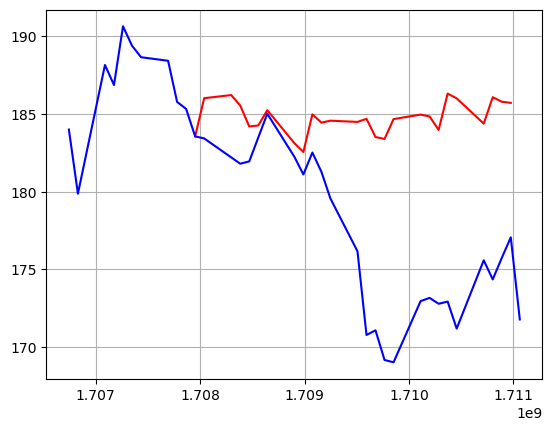

In [24]:
def print_new_predictions(count,name):
  prediction, df = get_prediction(count, name)
  print(prediction.tail(20))
  plot_prediction(prediction, df, count+1)

print_new_predictions(25,"AAPL")

Het printen van de nieuwe voorspelde waardes in een grafiek

C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Date"] = last_row["Date"].apply(next_day);
C:\Users\timmo\AppData\Local\Temp\ipykernel_8124\1533887341.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

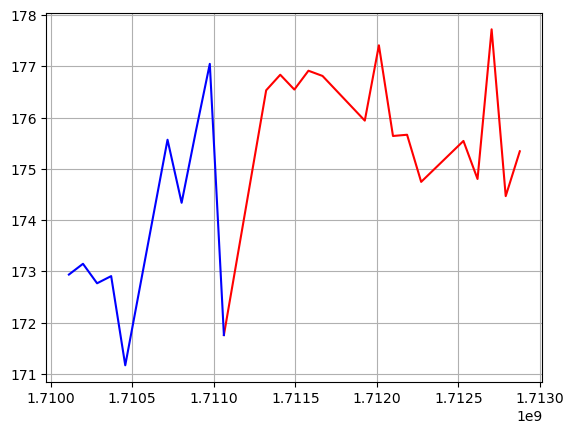

In [25]:
def print_new_predictions(count,name):
  df = download_data(name)
  df = get_df_ready(df, count*2);
  prediction = predict_new_rows(count, df)
  # print(prediction.tail(15))
  plt.plot(prediction['Date'].iloc[-(count+1):] ,prediction["Open"].iloc[-(count+1):] , color='r')
  plt.plot(df["Date"].iloc[-10:], df["Open"].iloc[-10:], label="Werkelijke waarden", color='b')
  plt.grid()
  plt.show()

print_new_predictions(15,"AAPL")